# Lab 4. Data structures and arrays
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

Due: Sept. 21, 2023

---------

In [2]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import netCDF4 as nc

%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens

### Using data structures to categorize data

The file 'worldwide_m4+_2022.csv' (on canvas) contains all earthquakes larger than magnitude 4 recorded by the USGS in 2022 (more than 15,000 events). Let's use a dictionary to keep track of how many events happened in each state.

First, read the data into python using pandas. The column 'place' contains a short description of the location of each event, and if it occurred in the US, this description will (usually) mention a state name. We can find out if a string is contained in another string using the keyword 'in' (see the notes).

Instructions: loop over the list of state names, and for each state count the number of M4+ earthquakes that occurred in that state (you may need to loop over the whole dataset for each state name). Add this number to a dictionary with the state name as the key; for example it might contain 'New Mexico': 4.

Finally, print out the top 10 states by number of earthquakes in 2022.

In [4]:
# use this list of states as the keys of your dictionary.
us_states = [ "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", 
             "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
             "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", 
             "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
             "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", 
             "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
             "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", 
             "Wisconsin", "Wyoming"]

worldwidem4 = pd.read_csv('./worldwide_m4+_2022.csv')

us_eq_dict = {}

for state in us_states: # Iterates through each state
    state_mention_counter = 0
          
    for index in worldwidem4.index: # Iterates through each row and pulls the place name
        place = worldwidem4['place'][index]
        
        if type(place) == str: # Blank space names reading as float - checks for invalid
            if state in place:
                state_mention_counter += 1
                
    us_eq_dict[state] = state_mention_counter

sorted_us_eq_dict = sorted(us_eq_dict.items(), key = lambda x:x[1], reverse=True)
    
print(sorted_us_eq_dict[0:10])  


[('Alaska', 401), ('Oregon', 23), ('Hawaii', 19), ('Texas', 12), ('Georgia', 10), ('New Mexico', 9), ('California', 4), ('Colorado', 3), ('Nevada', 3), ('Arizona', 1)]


### Resampling a dataset

Often times, our data have values missing, large errors, or are unevenly sampled. In this case, we need to 'resample' the data onto a regular grid. This is also known as 'gridding' the data.

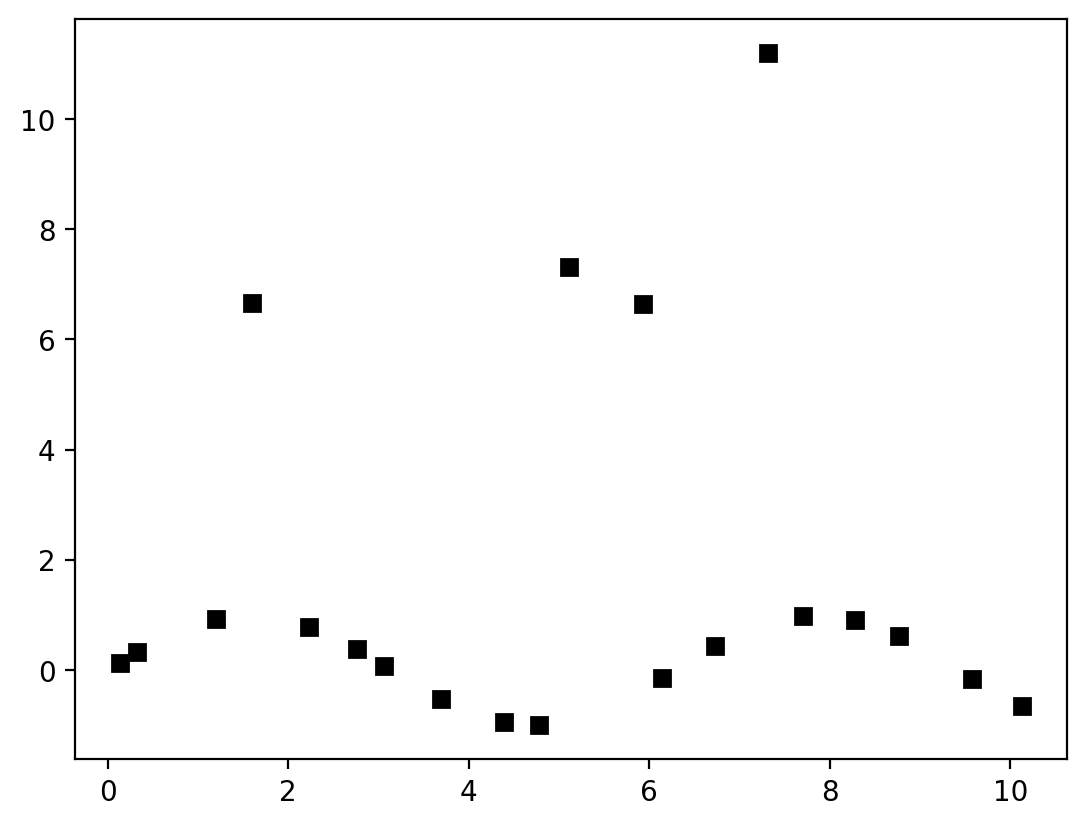

In [12]:
# original data - slight variation in the time sampling
times = np.linspace(0, 10, 20) +  np.random.uniform(-0.2, 0.2, 20)
values = np.sin(times)
# add some bad data
ibad=np.random.randint(2,18,(4,))
values[ibad] += 5+10*np.random.rand(4)
# plot the data
plt.plot(times,values,'ks',label='original')

### Assignment 1: remove outliers and resample the above data 

Step 1. Remove the outliers using logical indexing.

Step 2. Resample the remaining data onto a regularly spaced set of points sampled every 0.1 seconds, from 0 to 10. You can choose the interpolation method you find best!

Step 3. Plot the resampled data on top of the original data (without outliers), showing how the inerpolation works.

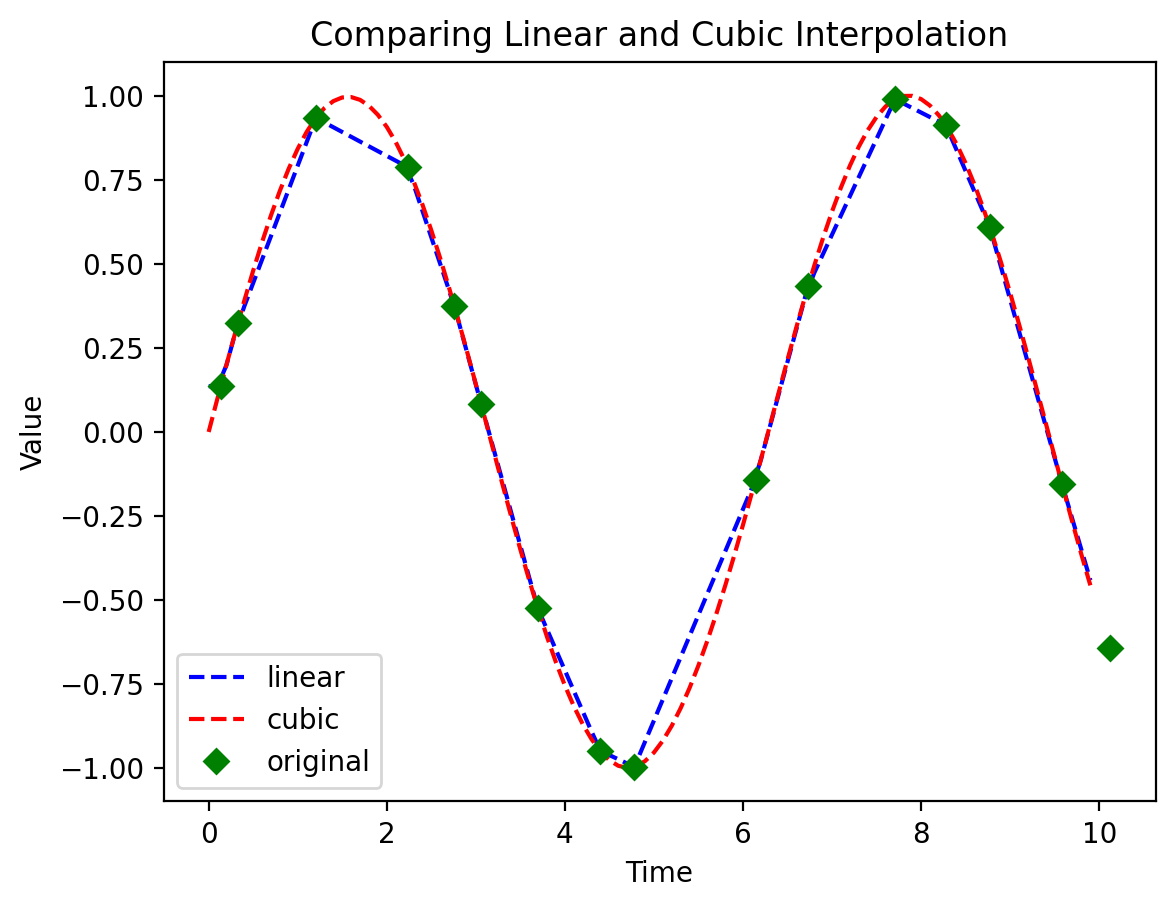

In [26]:
problem_index = np.where(values > 3)[0]

filtered_values = np.delete(values, problem_index)
filtered_times = np.delete(times, problem_index)

def linear_interp_values(time):
    return np.interp(time, filtered_times, filtered_values)

cubic_interp_values = interpolate.interp1d(filtered_times, filtered_values, kind='cubic', fill_value='extrapolate')
def cubic_interp_seismic_velocity(time):
    return cubic_interp_values(time)

timelist = np.arange(0,10,0.1)

val_linear = linear_interp_values(timelist)
val_cubic = cubic_interp_values(timelist)

plt.plot(timelist, val_linear, '--b', label='linear')
plt.plot(timelist, val_cubic, '--r', label='cubic')
plt.plot(filtered_times, filtered_values, 'gD', label='original')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparing Linear and Cubic Interpolation')
plt.legend()
plt.show()

### Assignment 2. Use 2D Interpolation to fill in the continents.

Remember our averaged-monthly SST dataset? (Filename: 'sst.mon.ltm.1981-2010.nc') Let's use this as a (strange) example of interpolation. Try masking out the NaNs in the grid of temperatures from September, then use griddata to fill in all the values over the continents.

I think this will prove a litte challenging - good luck, work with each other!

(180, 360)


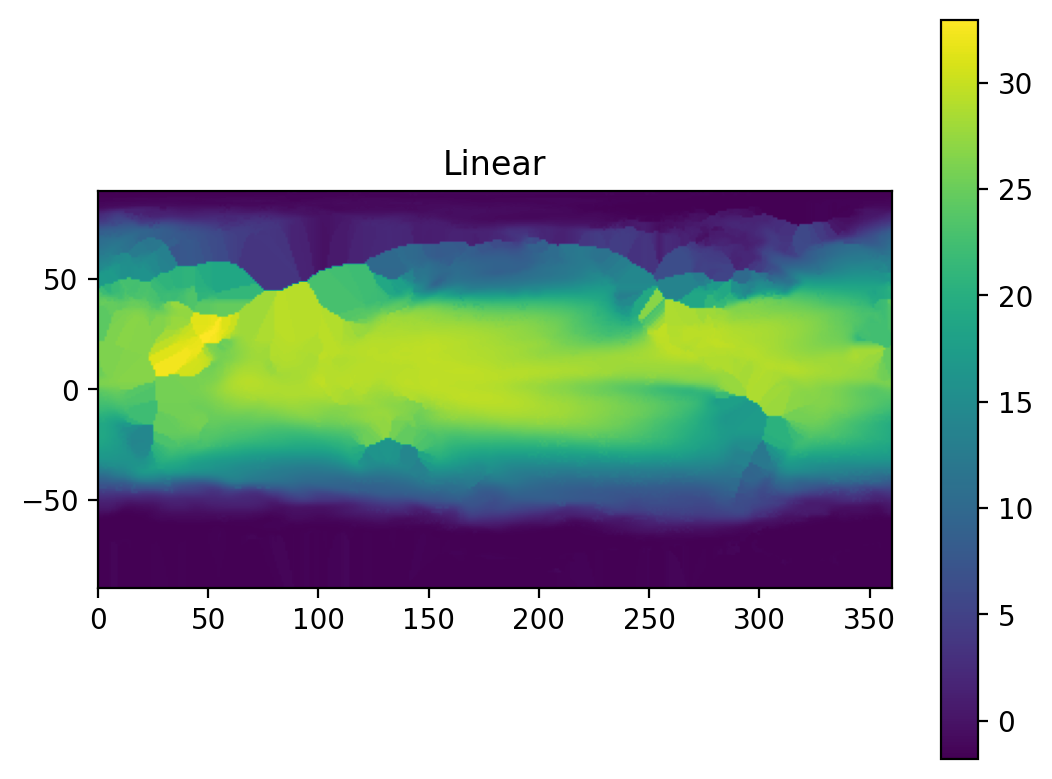

In [3]:
# here is some code to get you started.
# note you will have to copy the data file into your current folder for it to work for you.

filename = './sst.mon.ltm.1981-2010-1.nc'
dataset = nc.Dataset(filename)

# sst is stored as a 3D array (time,lat,lon)
# get the grid in September
sst_sept=dataset['sst'][8,:,:]

# Hint: note that this netCDF dataset comes with a 'mask' property that lets us know which values are NaN.
# we can access them with sst_sept.mask

zvalid = sst_sept[~sst_sept.mask]

"""
# check the shapes:
print('shape of sst_sept is', np.shape(sst_sept))
# notice, now it became a vector instead of an array.
print('shape of zvalid is', np.shape(zvalid))
"""

print(sst_sept.shape)

lons = dataset['lon'][:] # Pulls the longitudes as a vector with dimension (360,)
lats = dataset['lat'][:] # Pulls the latitudes as a vector with dimension (180,)

interp_lon_vector = np.arange(0, 360, 1) # Creates an interpolation vector with dimension (360,)
interp_lat_vector = np.arange(-90, 90, 1) # Creates an interpolation vector with dimension (180,)

interp_grid_lon, interp_grid_lat = np.meshgrid(interp_lon_vector, interp_lat_vector)

grid_lons, grid_lats = np.meshgrid(lons, lats) # Creates a mesh grid of the REAL lats and lons

lons_valid = grid_lons[~sst_sept.mask] # Uses the sst_sept mask to only pull the lats and lons corresponding to valid SST values
lats_valid = grid_lats[~sst_sept.mask]

grid_z = interpolate.griddata((lons_valid, lats_valid), zvalid, (interp_grid_lon, interp_grid_lat), method='nearest')



plt.imshow(grid_z, extent=(0, 360, -90, 90), origin='lower')
plt.title('Linear')
plt.colorbar()
plt.show()

#### I suggest the following procedure:

**Step 1. Generate the gridded X and Y matrices**

Use np.meshgrid on the dataset['lon'] and dataset['lat'] vectors.
Make sure to verify that your output arrays have the same size as your SST data.

**Step 2. Extract the valid points from each of your 3 arrays (X, Y, SST)**

Check out the hint above for how to use the mask property of the netcdf dataset.

**Step 3. Choose an interpolation method and do the interpolation from the scattered valid data back to the full X and Y grids**

**Step 4. Mask the ocean areas to show just the continents. You should end up with something cool!**